In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
import warnings
from sklearn.exceptions import ConvergenceWarning



# Arguments

In [298]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        }

all_layer_args = {
        'learning rate':0.01,
        'training epochs':5000,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

one_layer_args = {
        'learning rate':0.01,
        'training epochs':1000,

        'feature threshold':0.2,
        'dropout':0.5,
        'hidden layers':3,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [299]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [300]:
all_layer_df = pd.read_excel('data_3nm.xlsx')
one_layer_df = pd.read_excel('data_3nm.xlsx')

all_spec = all_layer_df.iloc[:,11:]
all_temp = all_layer_df.iloc[:,:11]

one_spec = one_layer_df.iloc[:,11:]
one_temp = one_layer_df.iloc[:,:11]

In [301]:
all_spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [302]:
one_spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [303]:
# scale spectrum data by 10^12
all_spec = all_spec.apply(lambda x: x*args['spec scale'])
one_spec = one_spec.apply(lambda x: x*args['spec scale'])

In [304]:
# add noise
all_noise = np.random.normal(loc=0, scale=args['noise'], size=all_spec.shape)
one_noise = np.random.normal(loc=0, scale=args['noise'], size=one_spec.shape)

all_spec_noisy = all_spec + all_noise
one_spec_noisy = one_spec + one_noise

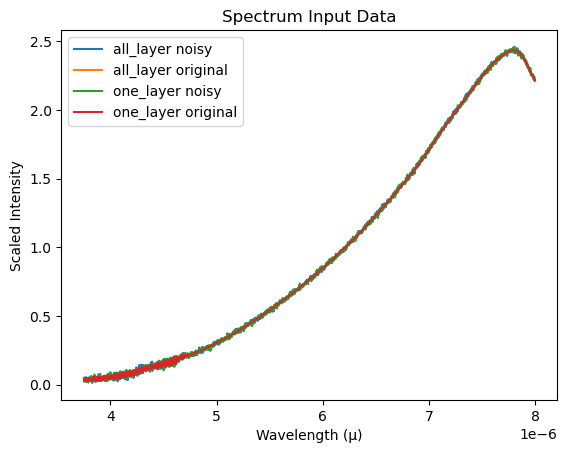

In [305]:
plt.title('Spectrum Input Data')
plt.plot(all_spec_noisy.iloc[0], label='all_layer noisy')
plt.plot(all_spec.iloc[0], label='all_layer original')
plt.plot(one_spec_noisy.iloc[0], label='one_layer noisy')
plt.plot(one_spec.iloc[0], label='one_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [306]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

# all_layer
scaler.fit(all_spec)
all_spec_scaled = scaler.transform(all_spec)

scaler.fit(all_spec_noisy)
all_spec_noisy_scaled = scaler.transform(all_spec_noisy)

all_spec_scaled_df = pd.DataFrame(all_spec_scaled, columns=all_spec.columns)
all_spec_noisy_scaled_df = pd.DataFrame(all_spec_noisy_scaled, columns = all_spec.columns)

# one_layer
scaler.fit(one_spec)
one_spec_scaled = scaler.transform(one_spec)

scaler.fit(one_spec_noisy)
one_spec_noisy_scaled = scaler.transform(one_spec_noisy)

one_spec_scaled_df = pd.DataFrame(one_spec_scaled, columns=one_spec.columns)
one_spec_noisy_scaled_df = pd.DataFrame(one_spec_noisy_scaled, columns = one_spec.columns)

/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklea

In [307]:
one_spec_noisy_scaled_df

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,1.446836,0.241291,0.782473,0.709449,-0.522934,0.764796,1.117045,0.714136,0.862115,-0.348017,...,-0.315696,-0.312876,-0.310349,-0.312921,-0.299468,-0.321500,-0.306521,-0.298189,-0.317239,-0.309369
1,-1.422335,-0.432736,-0.581587,-1.066058,0.202640,0.334781,-1.013728,0.934056,0.348059,0.433392,...,-0.796075,-0.790738,-0.791892,-0.803606,-0.810367,-0.805709,-0.801942,-0.793200,-0.807756,-0.803261
2,1.860279,0.458783,1.609595,0.019581,0.344718,0.276900,-0.079803,0.766396,1.009454,0.877519,...,1.276960,1.260623,1.273959,1.292526,1.266130,1.264627,1.278819,1.276085,1.267332,1.275944
3,-1.526238,-1.840456,-1.645652,-0.830229,-0.461267,-2.055624,-2.363779,-2.393461,-0.410718,0.096909,...,0.032175,0.022530,0.019976,0.026897,0.039026,0.035932,0.038530,0.026228,0.032552,0.020714
4,-0.669437,0.173941,-1.004732,0.326529,0.426472,-0.486564,0.670592,0.587952,-0.141213,-1.246314,...,0.288948,0.308520,0.293916,0.297659,0.295016,0.308480,0.289004,0.296948,0.294525,0.284837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.474987,1.032047,1.224506,-0.008717,-0.319870,0.622927,1.092750,0.187459,0.257745,1.051683,...,1.369230,1.377692,1.366609,1.380418,1.364464,1.360541,1.363027,1.372669,1.370423,1.364550
2196,1.474563,1.165092,1.071220,2.355433,2.104294,1.194109,-0.386148,1.077848,-0.395180,1.338886,...,0.853248,0.856458,0.848631,0.858537,0.854427,0.856944,0.869487,0.860309,0.861982,0.862381
2197,0.527419,-0.936127,-1.038748,0.090205,-0.557934,0.331838,0.470603,-0.565870,0.349473,0.951656,...,0.413651,0.414681,0.420036,0.428293,0.413386,0.398436,0.409311,0.413951,0.410388,0.408872
2198,0.949940,0.618718,0.500161,0.736621,0.125364,-1.251967,1.565204,0.803734,1.035547,-0.932494,...,0.585123,0.584093,0.586163,0.580596,0.574508,0.576465,0.584038,0.577669,0.587228,0.580358


In [308]:
all_spec_noisy_scaled_df

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,1.529014,-0.252207,0.674579,0.888232,0.602892,0.318466,2.027496,0.109798,0.985921,-0.118116,...,-0.307798,-0.312942,-0.301224,-0.312103,-0.305481,-0.307956,-0.313131,-0.296733,-0.312476,-0.307570
1,-0.452639,-1.256170,-0.706134,-0.891105,-1.568746,-0.466628,0.392860,-0.084590,0.098933,-0.558015,...,-0.796778,-0.801930,-0.805906,-0.790657,-0.809732,-0.792911,-0.808412,-0.795589,-0.814053,-0.800135
2,0.129304,1.606925,0.589697,0.082598,0.980958,1.039994,0.636129,-0.646951,0.333373,0.758427,...,1.267089,1.280306,1.283477,1.273098,1.263304,1.272827,1.276311,1.274744,1.281289,1.296080
3,-2.966064,-0.498691,-1.512960,-1.185285,-1.842074,-1.674378,-0.806592,-1.219192,-1.796205,-1.965975,...,0.032753,0.036532,0.030489,0.023388,0.029131,0.028976,0.036725,0.031643,0.027157,0.037209
4,-0.461909,-1.602157,1.089447,-0.252005,1.182073,-0.041589,-0.354189,0.564801,-0.435781,0.961834,...,0.291955,0.297336,0.289264,0.295525,0.286688,0.295794,0.300269,0.300566,0.287763,0.289268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.038429,0.321054,0.857371,0.092017,-0.282873,-0.618496,1.343826,0.369522,0.497211,0.185515,...,1.352695,1.361590,1.368376,1.369253,1.367171,1.362923,1.366707,1.361376,1.355876,1.362365
2196,1.027740,1.455571,0.671225,2.211623,1.795586,2.079420,1.051236,0.066036,1.280585,0.291647,...,0.857985,0.877929,0.859146,0.863888,0.857104,0.854433,0.854572,0.857347,0.862089,0.861370
2197,0.737653,-0.186576,-1.006115,0.406152,0.747638,-0.225867,0.053577,-0.274012,-0.813000,-1.123295,...,0.406509,0.412154,0.409605,0.407644,0.427854,0.413109,0.403791,0.428081,0.426574,0.406670
2198,-0.737214,1.069073,0.379248,0.472779,-0.962609,-0.406334,-0.131985,-0.983992,0.058331,0.694626,...,0.575613,0.585468,0.577305,0.575719,0.585806,0.580317,0.565858,0.586518,0.575370,0.579491


In [309]:
all_temp

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,318.002181
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,301.044787
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,357.969610
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,328.143455
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,335.245173
...,...,...,...,...,...,...,...,...,...,...,...
2195,327.359960,331.887028,335.439802,327.858751,329.905634,332.466652,323.482462,319.992829,334.062241,326.323524,359.801763
2196,354.311013,341.927755,337.451821,323.967416,330.097748,313.792185,317.839648,318.627400,331.026918,344.846164,348.886578
2197,345.013997,323.826484,315.340107,306.337376,314.184375,306.270021,304.561202,313.513715,321.161351,326.559357,338.238519
2198,309.706144,313.843492,332.026895,338.820759,345.317550,352.584174,339.603698,337.521742,337.254720,328.544064,342.340353


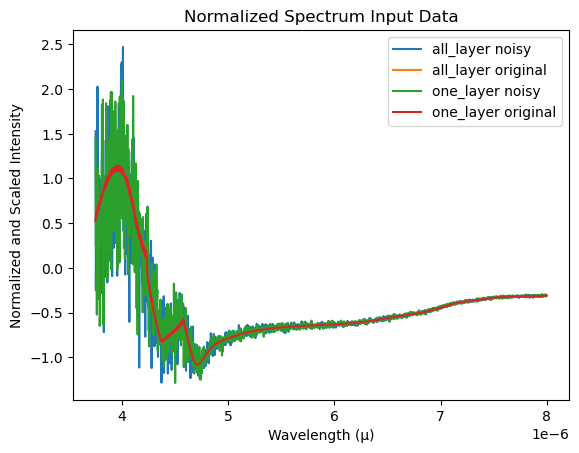

In [310]:
plt.title('Normalized Spectrum Input Data')
plt.plot(all_spec_noisy_scaled_df.iloc[0], label='all_layer noisy')
plt.plot(all_spec_scaled_df.iloc[0], label='all_layer original')
plt.plot(one_spec_noisy_scaled_df.iloc[0], label='one_layer noisy')
plt.plot(one_spec_scaled_df.iloc[0], label='one_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [311]:
all_spec_train_df, all_spec_test_df, all_temp_train_df, all_temp_test_df = train_test_split(all_spec_noisy_scaled_df, all_temp, train_size=args['percent training data'], random_state=101)

all_spec_train = df_to_tensor(all_spec_train_df)
all_spec_test = df_to_tensor(all_spec_test_df)
all_temp_train = df_to_tensor(all_temp_train_df)
all_temp_test = df_to_tensor(all_temp_test_df)

In [312]:
one_spec_train_df, one_spec_test_df, one_temp_train_df, one_temp_test_df = train_test_split(one_spec_noisy_scaled_df, one_temp, train_size=args['percent training data'], random_state=101)

one_spec_train = df_to_tensor(all_spec_train_df)
one_spec_test = df_to_tensor(all_spec_test_df)
one_temp_train = df_to_tensor(all_temp_train_df)
one_temp_test = df_to_tensor(all_temp_test_df)

In [313]:
one_temp_train

tensor([[279.2097, 291.1372, 304.6712,  ..., 309.0874, 307.9146, 287.3898],
        [284.7944, 309.4465, 334.0897,  ..., 303.7473, 311.2545, 366.0722],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [293.5930, 300.5022, 312.8386,  ..., 306.9922, 292.7501, 293.1349],
        [337.4347, 345.6631, 344.0024,  ..., 324.8639, 323.7931, 333.0087],
        [293.4902, 286.4892, 303.6414,  ..., 345.2938, 341.2333, 361.8345]])

In [314]:
one_temp_train_df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
805,279.209743,291.137221,304.671212,321.530815,329.446994,327.029105,313.960558,324.310987,309.087402,307.914547,287.389829
1798,284.794420,309.446547,334.089700,350.676110,338.351686,338.961686,320.533221,304.078196,303.747342,311.254536,366.072198
193,303.578596,296.012106,320.139477,331.612634,343.149874,341.599287,327.050020,312.050438,300.909822,290.052707,305.241303
162,281.108362,326.802138,327.622403,330.956774,328.315642,325.316098,330.881045,323.297827,335.718231,335.832163,359.882238
1211,305.883115,309.732322,311.271401,307.804161,319.833550,314.919764,314.269008,322.242702,336.473803,341.159050,359.702423
...,...,...,...,...,...,...,...,...,...,...,...
599,289.901273,303.797299,314.640206,322.380250,322.906980,334.804410,332.806097,340.696287,332.441968,326.199472,287.329896
1599,332.949636,338.770840,326.556094,318.249358,324.882489,324.553302,316.494734,332.146005,345.986547,338.350044,360.618668
1361,293.593005,300.502237,312.838567,309.084343,316.565921,318.843820,304.805597,303.329649,306.992251,292.750057,293.134899
1547,337.434701,345.663135,344.002401,350.968885,344.162538,341.646016,347.224707,332.715609,324.863918,323.793078,333.008666


# Feature Selection

In [315]:
# create list of layer dictionaries for one_layer model
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})
    
print(layers)

[{'layer': 1, 'col': 'layer 1'}, {'layer': 2, 'col': 'layer 2'}, {'layer': 3, 'col': 'layer 3'}, {'layer': 4, 'col': 'layer 4'}, {'layer': 5, 'col': 'layer 5'}, {'layer': 6, 'col': 'layer 6'}, {'layer': 7, 'col': 'layer 7'}, {'layer': 8, 'col': 'layer 8'}, {'layer': 9, 'col': 'layer 9'}, {'layer': 10, 'col': 'layer 10'}, {'layer': 11, 'col': 'layer 11'}]


In [316]:
# feature selection
for layer in layers:
    targets = one_temp[(layer['col'])]

    lasso = LassoCV(max_iter=1000)
    lasso.fit(one_spec_noisy_scaled_df, targets)
    selected_features = one_spec.columns[abs(lasso.coef_) >= one_layer_args['feature threshold']]

    layer['features'] = selected_features

    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')

/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 1 (103):
 Index([3.756e-06, 3.801e-06, 3.807e-06, 3.825e-06, 3.831e-06, 3.843e-06,
       3.852e-06, 3.882e-06, 3.891e-06, 3.897e-06,
       ...
       4.674e-06, 4.677e-06,  4.68e-06, 4.686e-06, 4.692e-06, 4.698e-06,
       4.704e-06, 4.917e-06,  5.07e-06, 5.946e-06],
      dtype='object', length=103)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 2 (317):
 Index([ 3.75e-06, 3.753e-06, 3.759e-06, 3.762e-06, 3.765e-06, 3.768e-06,
       3.774e-06, 3.777e-06, 3.801e-06, 3.804e-06,
       ...
       7.323e-06,  7.38e-06, 7.386e-06, 7.398e-06, 7.446e-06, 7.455e-06,
       7.488e-06, 7.512e-06, 7.518e-06, 7.596e-06],
      dtype='object', length=317)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 3 (330):
 Index([3.753e-06, 3.759e-06, 3.762e-06, 3.765e-06, 3.771e-06, 3.777e-06,
        3.78e-06, 3.786e-06, 3.789e-06, 3.792e-06,
       ...
       7.329e-06, 7.335e-06, 7.359e-06, 7.374e-06, 7.407e-06,  7.44e-06,
       7.473e-06, 7.482e-06, 7.518e-06, 7.545e-06],
      dtype='object', length=330)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 4 (288):
 Index([3.762e-06, 3.777e-06,  3.78e-06, 3.795e-06, 3.798e-06, 3.807e-06,
       3.822e-06, 3.834e-06, 3.846e-06, 3.849e-06,
       ...
       7.323e-06, 7.371e-06, 7.374e-06, 7.431e-06,  7.44e-06, 7.452e-06,
       7.467e-06, 7.512e-06, 7.515e-06, 7.647e-06],
      dtype='object', length=288)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 5 (103):
 Index([3.765e-06, 3.771e-06, 3.789e-06, 3.819e-06, 3.831e-06, 3.849e-06,
       3.855e-06, 3.894e-06, 3.897e-06,   3.9e-06,
       ...
       7.434e-06, 7.443e-06, 7.467e-06, 7.488e-06, 7.494e-06,   7.5e-06,
       7.518e-06, 7.545e-06, 7.566e-06, 7.743e-06],
      dtype='object', length=103)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 6 (303):
 Index([ 3.75e-06, 3.774e-06, 3.777e-06, 3.786e-06, 3.801e-06, 3.825e-06,
       3.828e-06, 3.834e-06, 3.852e-06, 3.855e-06,
       ...
       7.389e-06, 7.398e-06, 7.437e-06,  7.44e-06, 7.446e-06, 7.467e-06,
       7.485e-06, 7.488e-06, 7.503e-06, 7.509e-06],
      dtype='object', length=303)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 7 (286):
 Index([3.789e-06, 3.822e-06, 3.825e-06, 3.828e-06, 3.834e-06, 3.837e-06,
        3.84e-06, 3.849e-06, 3.852e-06, 3.885e-06,
       ...
       7.374e-06, 7.377e-06,  7.38e-06, 7.398e-06, 7.431e-06, 7.437e-06,
       7.446e-06, 7.485e-06, 7.524e-06, 7.545e-06],
      dtype='object', length=286)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 8 (220):
 Index([3.771e-06, 3.786e-06, 3.792e-06, 3.804e-06, 3.834e-06, 3.855e-06,
       3.867e-06,   3.9e-06, 3.912e-06, 3.942e-06,
       ...
       5.271e-06, 5.274e-06, 5.295e-06, 5.409e-06, 6.597e-06, 6.666e-06,
       6.789e-06, 6.822e-06, 6.843e-06, 6.945e-06],
      dtype='object', length=220)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 9 (262):
 Index([3.753e-06, 3.768e-06, 3.786e-06, 3.798e-06, 3.804e-06, 3.813e-06,
       3.825e-06, 3.831e-06, 3.834e-06, 3.849e-06,
       ...
       7.119e-06, 7.122e-06,  7.14e-06, 7.869e-06, 7.872e-06, 7.893e-06,
       7.902e-06, 7.932e-06, 7.956e-06, 7.971e-06],
      dtype='object', length=262)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 10 (419):
 Index([ 3.75e-06, 3.753e-06, 3.759e-06, 3.768e-06, 3.783e-06,  3.81e-06,
       3.813e-06, 3.819e-06, 3.822e-06, 3.825e-06,
       ...
        7.92e-06, 7.923e-06, 7.926e-06, 7.944e-06, 7.947e-06, 7.956e-06,
       7.962e-06, 7.971e-06, 7.989e-06, 7.995e-06],
      dtype='object', length=419)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 11 (187):
 Index([4.038e-06, 4.059e-06, 4.146e-06, 4.203e-06, 4.377e-06, 4.383e-06,
       4.386e-06, 4.389e-06, 4.392e-06, 4.395e-06,
       ...
        7.92e-06, 7.929e-06, 7.932e-06, 7.941e-06, 7.944e-06, 7.956e-06,
       7.971e-06, 7.974e-06, 7.989e-06, 7.992e-06],
      dtype='object', length=187)



In [317]:
for layer in layers:
    layer['temp_train'] = torch.tensor(one_temp_train_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['temp_test'] = torch.tensor(one_temp_test_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['spec_train'] = torch.tensor(one_spec_train_df[layer['features']].values, dtype=torch.float32)
    layer['spec_test'] = torch.tensor(one_spec_test_df[layer['features']].values, dtype=torch.float32)

# Model Design

In [318]:
class All_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(All_Layer_Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [319]:
class One_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(One_Layer_Net, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(one_layer_args['dropout'])

    def forward(self, x):

        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.dropout(x)
        x = self.lin_fin(x)
        return x

In [320]:
# define all_layer model
_, all_layer_output_size = all_temp.shape
_, all_layer_input_size = all_spec_noisy_scaled_df.shape
all_layer_model = All_Layer_Net(all_layer_input_size, all_layer_output_size)

# one_layer models are defined in training funciton

# Training Loops

In [321]:
# all_layer training

def train_all_layer(all_layer_model, all_spec_train):
    print('\nTRAINING ALL_LAYER MODEL')


    loss_list = []
    loss_sum = 0

    num_epochs = all_layer_args['training epochs']
    criterion = all_layer_args['loss fn']
    optimizer = all_layer_args['optimizer'](all_layer_model.parameters(), lr=all_layer_args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = all_layer_model(all_spec_train)

        # calculate loss
        loss = criterion(all_temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'epoch: {epoch + 1}, loss = {loss}')

    print(f'epoch: {epoch + 1}, loss = {loss}')

    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\naverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list

In [322]:
# one_layer training
def train_one_layer(One_Layer_Net):
    print('\nTRAINING ONE LAYER MODEL')
    criterion = one_layer_args['loss fn']

    for layer in layers:
        print(layer['col'])
        input = layer['spec_train']
        target = layer['temp_train']

        # instantiate model
        model = One_Layer_Net(input.size()[1], target.size()[1], one_layer_args['hidden layers'])

        best_loss = np.inf
        best_epoch = 0
        train_losses = []

        optimizer = torch.optim.Rprop(model.parameters(), lr=one_layer_args['learning rate'])

        print(f'hidden layer sizes: {model.hidden_sizes}')

        for epoch in range(one_layer_args['training epochs']):
            # forward pass
            outputs = model(input)

            # get loss
            loss = criterion(outputs, target)

            # update and backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch+1

            if (epoch+1) % int(one_layer_args['training epochs']/10) == 0:
                print(f'epoch: {epoch+1}, loss = {loss}')

        # store model and losses
        layer['model'] = model
        layer['train losses'] = train_losses

        print(f'best loss: {best_loss} in epoch {best_epoch}\n')

    return layers, train_losses    

In [323]:
all_loss_list = train_all_layer(all_layer_model, all_spec_train)


TRAINING ALL_LAYER MODEL
epoch: 500, loss = 4.401347637176514
epoch: 1000, loss = 4.17218017578125
epoch: 1500, loss = 4.107356071472168
epoch: 2000, loss = 4.08675479888916
epoch: 2500, loss = 4.073936462402344
epoch: 3000, loss = 4.0602192878723145
epoch: 3500, loss = 4.046807289123535
epoch: 4000, loss = 4.0329790115356445
epoch: 4500, loss = 4.02257776260376
epoch: 5000, loss = 4.012059211730957
epoch: 5000, loss = 4.012059211730957

average training loss (across all layers): 4.1571388973508565


In [324]:
layers, one_loss_list = train_one_layer(One_Layer_Net)


TRAINING ONE LAYER MODEL
layer 1
hidden layer sizes: [103, 77, 51, 25]
epoch: 500, loss = 8.164917945861816
epoch: 1000, loss = 7.892878532409668
epoch: 1500, loss = 7.656645774841309
epoch: 2000, loss = 8.056992530822754
epoch: 2500, loss = 7.853353977203369
epoch: 3000, loss = 7.628145217895508
epoch: 3500, loss = 7.692587852478027
epoch: 4000, loss = 7.921186923980713
epoch: 4500, loss = 7.679739475250244
epoch: 5000, loss = 7.9652299880981445
best loss: 7.325344562530518 in epoch 3288

layer 2
hidden layer sizes: [317, 237, 158, 79]
epoch: 500, loss = 8.575140953063965
epoch: 1000, loss = 7.4586615562438965
epoch: 1500, loss = 7.441061496734619
epoch: 2000, loss = 6.937997341156006
epoch: 2500, loss = 7.082733631134033
epoch: 3000, loss = 6.944546699523926
epoch: 3500, loss = 6.8687214851379395
epoch: 4000, loss = 6.876457214355469
epoch: 4500, loss = 6.896726608276367
epoch: 5000, loss = 6.974154472351074
best loss: 6.558791637420654 in epoch 4689

layer 3
hidden layer sizes: [33

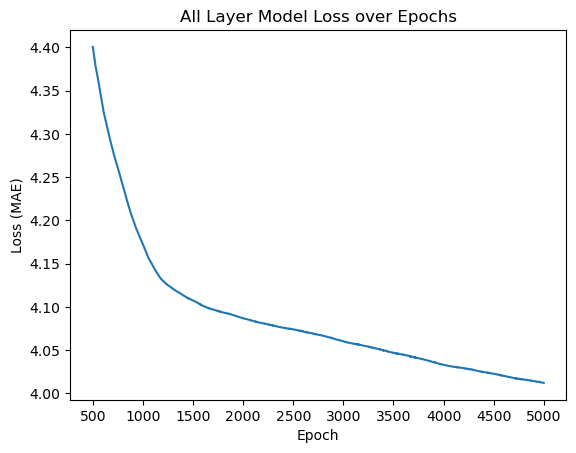

In [325]:
# plot all_layer loss over epochs

# add 500 to x-axis values
x_values = range(500, all_layer_args['training epochs'])
plt.plot(x_values, all_loss_list[500:])
plt.xticks(range(500, all_layer_args['training epochs'] + 500, all_layer_args['training epochs'] // 10))

plt.title("All Layer Model Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

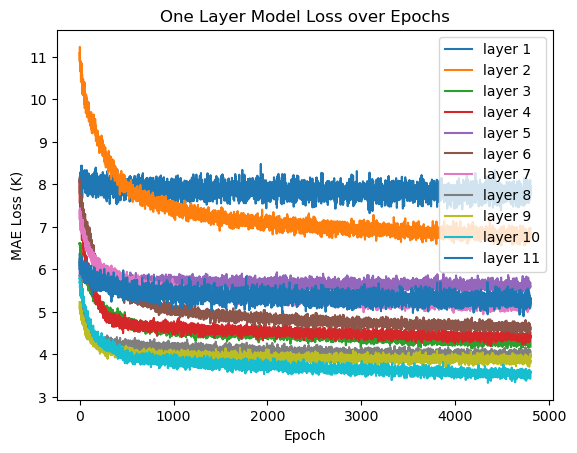

In [330]:
for layer in layers:
    plt.plot(layer['train losses'][200:], label=layer['col'])

    
plt.title(f"One Layer Model Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

# Testing

In [327]:
# test data with all_layer_model
pred_temp = all_layer_model(all_spec_test)

# test data with one_layer models


In [328]:
# unscale spectrum data
all_spec_test = scaler.inverse_transform(all_spec_test.detach().numpy())
one_spec_test = scaler.inverse_transform(all_spec_test.detach().numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [5.446449141068892, 9.620032038833155, 6.477518116344105, 5.526552905458392, 6.009165376605409, 6.593079561175722, 6.514166190407493, 4.7633680401426375, 4.826964060465495, 6.130161146684126, 2.3000924081513374]


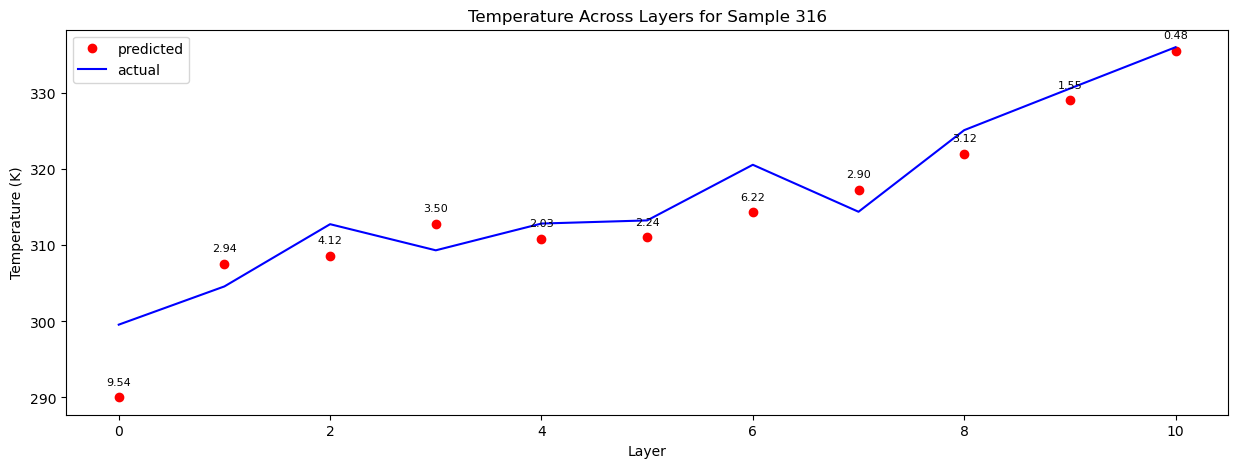

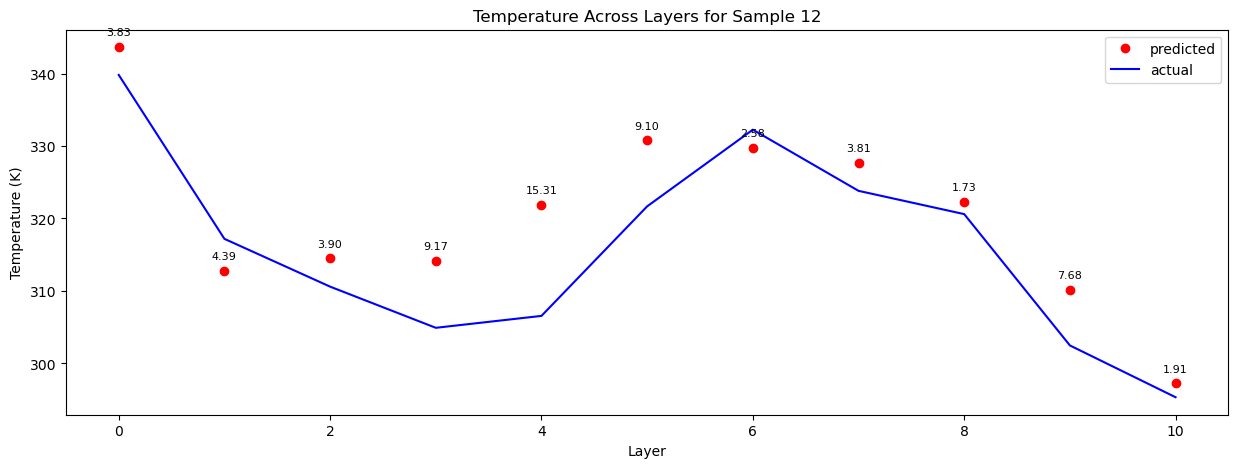

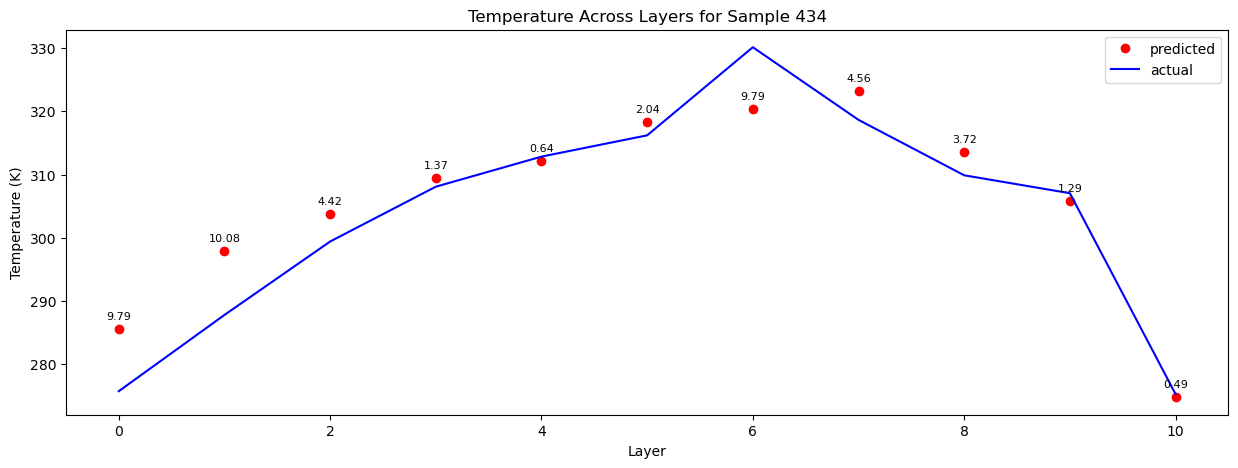

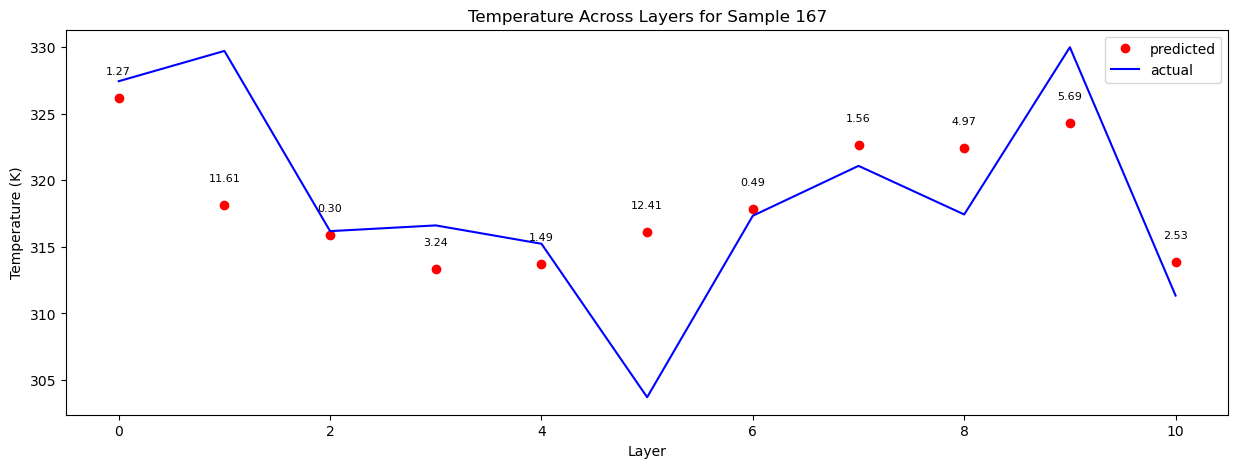

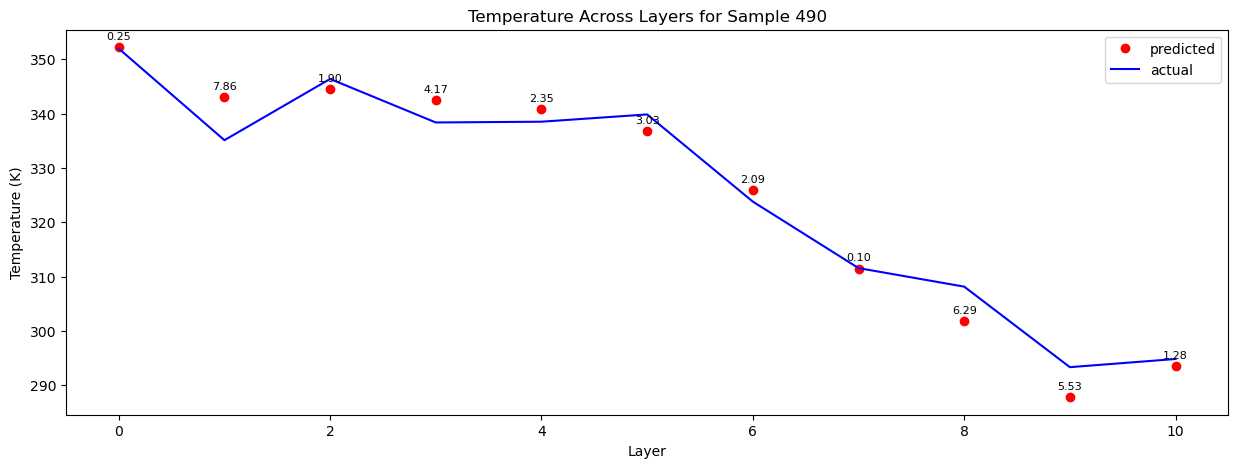

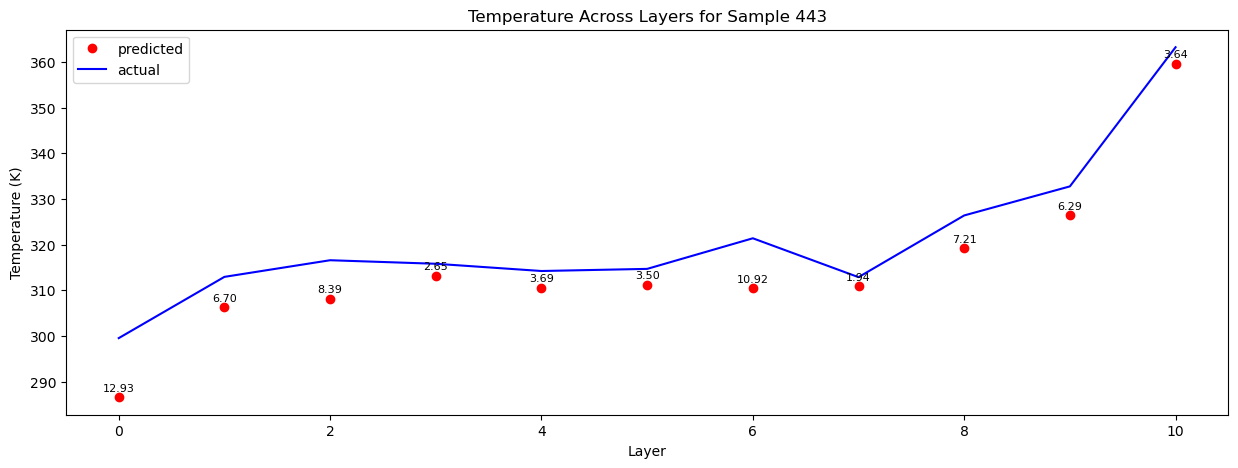

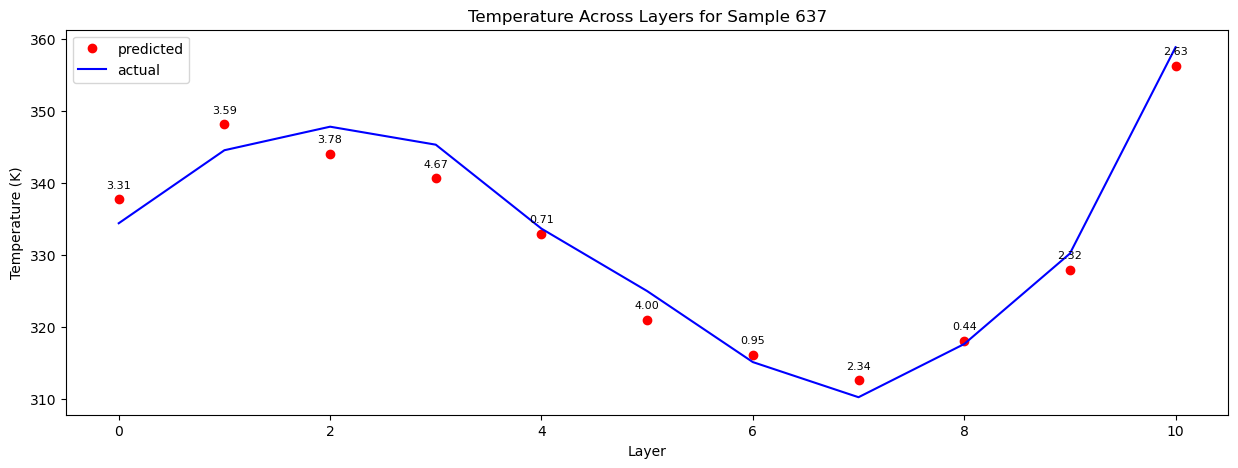

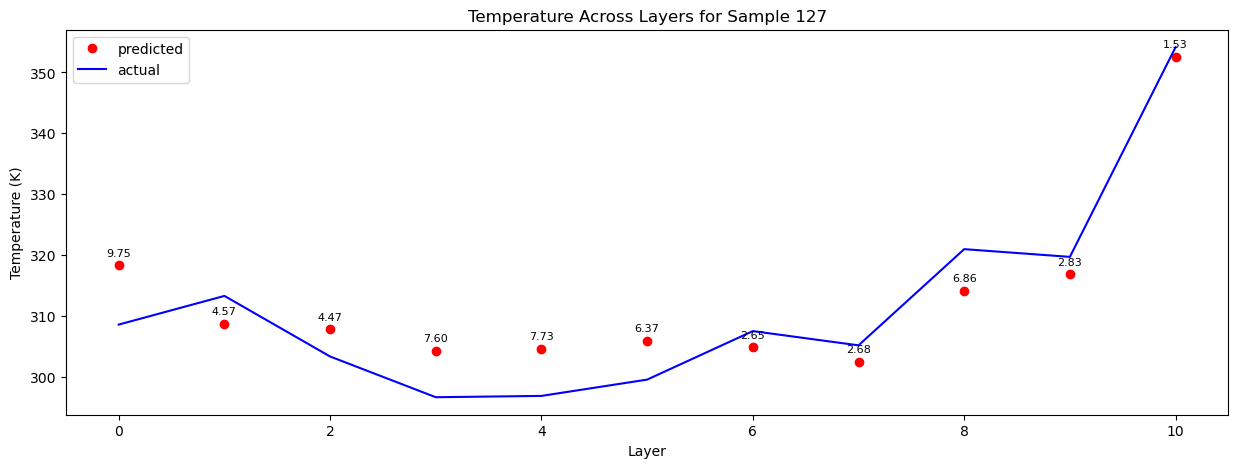

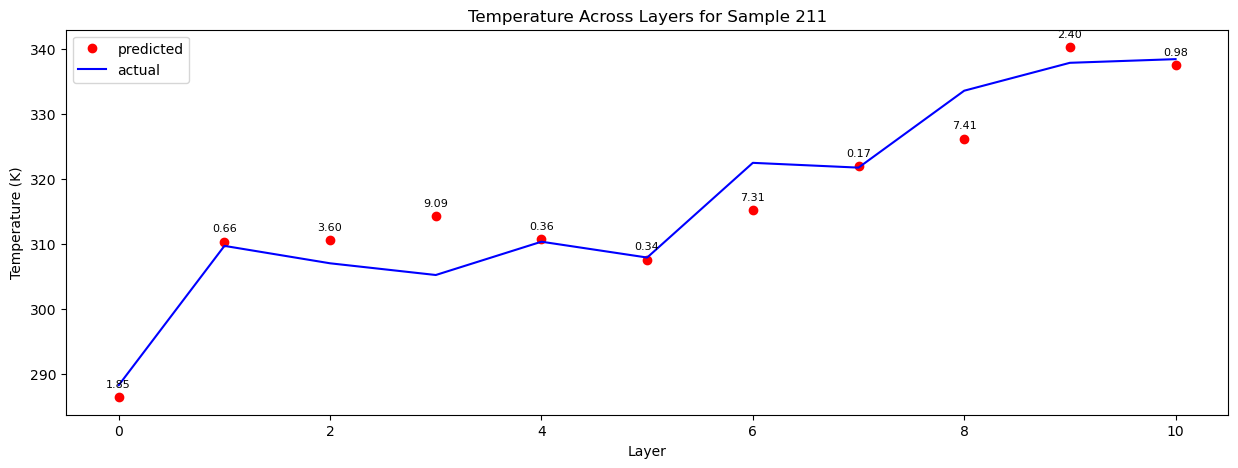

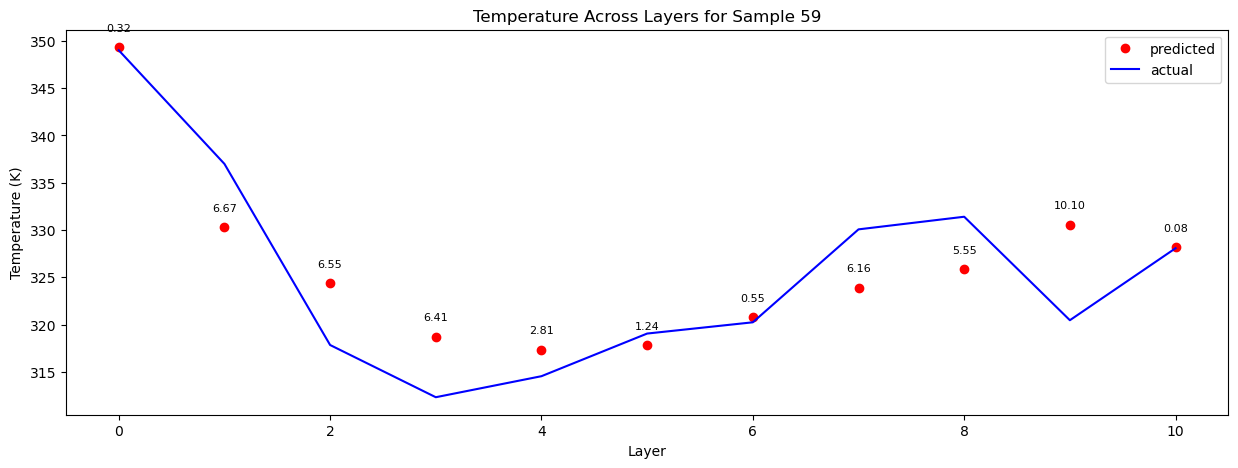

In [ ]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


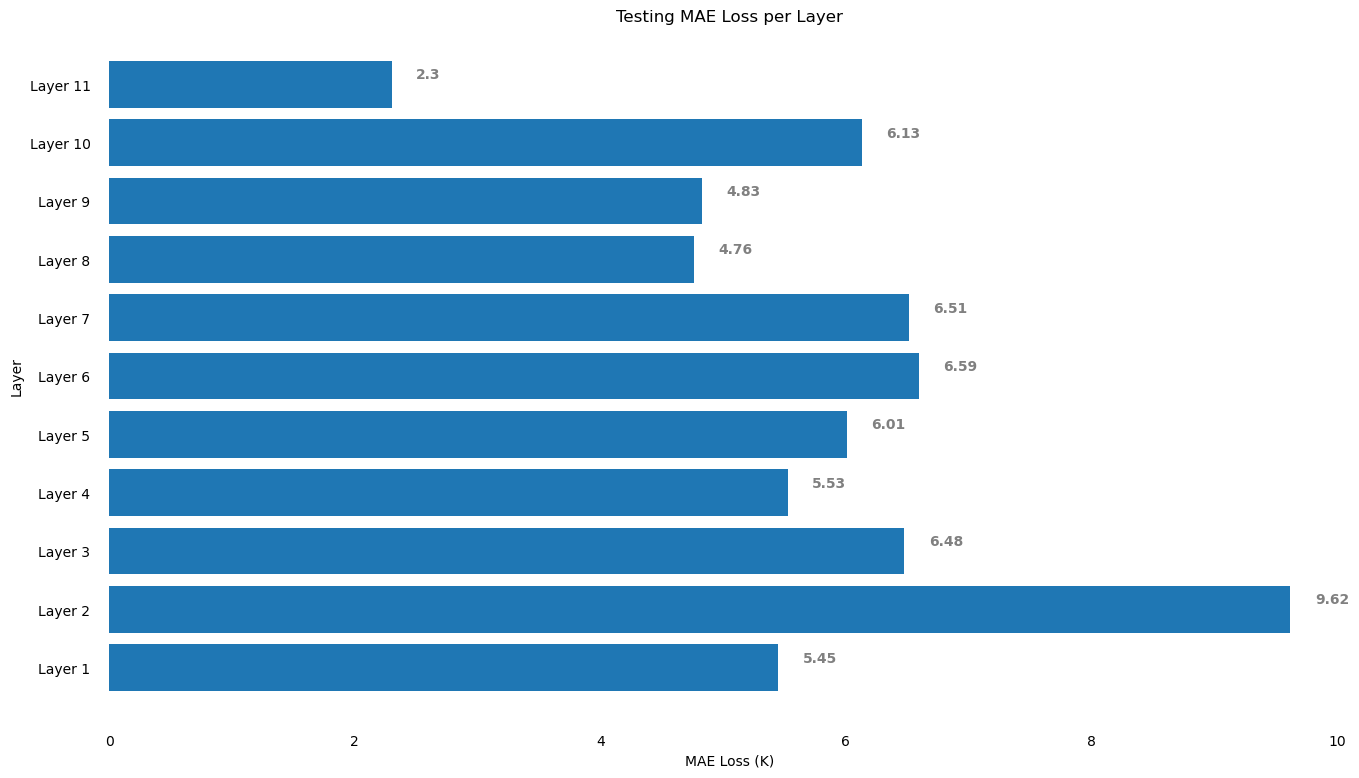

In [ ]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()